Dataset: https://archive.ics.uci.edu/ml/datasets/Contraceptive+Method+Choice

In [10]:
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import precision_recall_fscore_support
#from sklearn.metrics import accuracy_score, plot_confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')

# from imblearn.pipeline import Pipeline
# from imblearn.over_sampling import SMOTE
# from imblearn.under_sampling import RandomUnderSampler
# from imblearn.over_sampling import RandomOverSampler
# from collections import Counter




In [11]:
contra = pd.read_csv("contraceptive/contraceptive_for_students.csv")

1. Wife's age (numerical)
2. Wife's education (categorical) 1=low, 2, 3, 4=high
3. Husband's education (categorical) 1=low, 2, 3, 4=high
4. Number of children ever born (numerical)
5. Wife's religion (binary) 0=Non-Islam, 1=Islam
6. Wife's now working? (binary) 0=Yes, 1=No
7. Husband's occupation (categorical) 1, 2, 3, 4
8. Standard-of-living index (categorical) 1=low, 2, 3, 4=high
9. Media exposure (binary) 0=Good, 1=Not good
10. Contraceptive method used (class attribute) 1=No-use, 2=Long-term, 3=Short-term


In [12]:
contra.head()

,wife_age,wife_education,husband_education,num_child,wife_religion,wife_work,husband_occupation,standard_living,media_exposure,contraceptive
0,24,2,3,3,1,1,2,3,0,1
1,45,1,3,10,1,1,3,4,0,1
2,43,2,3,7,1,1,3,4,0,1
3,42,3,2,9,1,1,3,3,0,1
4,36,3,3,8,1,1,3,2,0,1


In [13]:
contra.isna().sum()

wife_age              0
wife_education        0
husband_education     0
num_child             0
wife_religion         0
wife_work             0
husband_occupation    0
standard_living       0
media_exposure        0
contraceptive         0
dtype: int64

*There are no null values in the code, so there is no need to drop or impute any of the values* 

In [14]:
contra['type'] = contra['contraceptive'].replace({1: 'No Use', 2: "Long Term", 3 : "Short Term"})

*Some of the features in the data such as num_child and wife_age are continuous valued features
with different units of measurement (children vs years). Next we define a function to standardize these
features as well as a basic feature transformation matrix that applies the standardize function
to a specific subset of features, in this case, num_child and wife_age.* 

In [15]:
def standardize(data, with_std = True):
    scaler = preprocessing.StandardScaler(with_std = with_std)
    columns = data.columns
    df = pd.DataFrame(scaler.fit_transform(data))
    df.columns = columns
    return df

*Much of the data represents categorical variables. Although it is already presented in numerical
form, the data must be one hot encoded, since a lot of the features, such as standard_living is ordinal,
that is, the data is ordered in some way, however there is no effective way to accurately asess how much better standard_living index of 1 is then 2.*

In [16]:
def phi0(X, columns):
    for column in columns:
        X[column] = standardize(X[[column]])[column]
    return X

In [17]:
def design(X, featurize = phi0):
    X = X.copy()
   
    categorical = X.copy()[['wife_education', 'husband_education', 'husband_occupation',
       'standard_living']]
    other = contra[['wife_age', 'num_child', "wife_work", "media_exposure"]]
    #one hot encode the categorical data
    encoder = preprocessing.OneHotEncoder()
    one_hot = pd.DataFrame(encoder.fit_transform(categorical).toarray())
    ohe_columns = ["wife_edu1", "wife_edu2", "wife_edu3", "wife_edu4", "hus_edu1", "hus_edu2", "hus_edu3", "hus_edu4", 
           "hus_occ1", "hus_occ2", "hus_occ3", "hus_occ4", "std_living1", "std_living2", "std_living3", 
           "std_living4"]
    one_hot.columns = ohe_columns
    contra_clean = other.join(one_hot)
    return featurize(contra_clean, columns = ['wife_age', 'num_child'])

## EDA

#### First we will check the proportions of the classes

Text(0.5, 1.0, 'Number of Samples in Each Class')

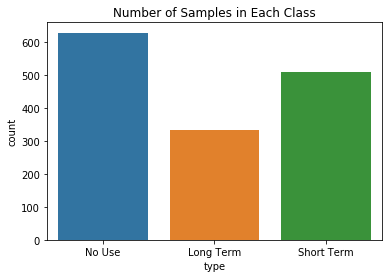

In [18]:
sns.countplot(data=contra, x = 'type')
plt.title("Number of Samples in Each Class")

#### Correlation between Features

Text(0.5, 1.0, 'Heatmap of the given features')

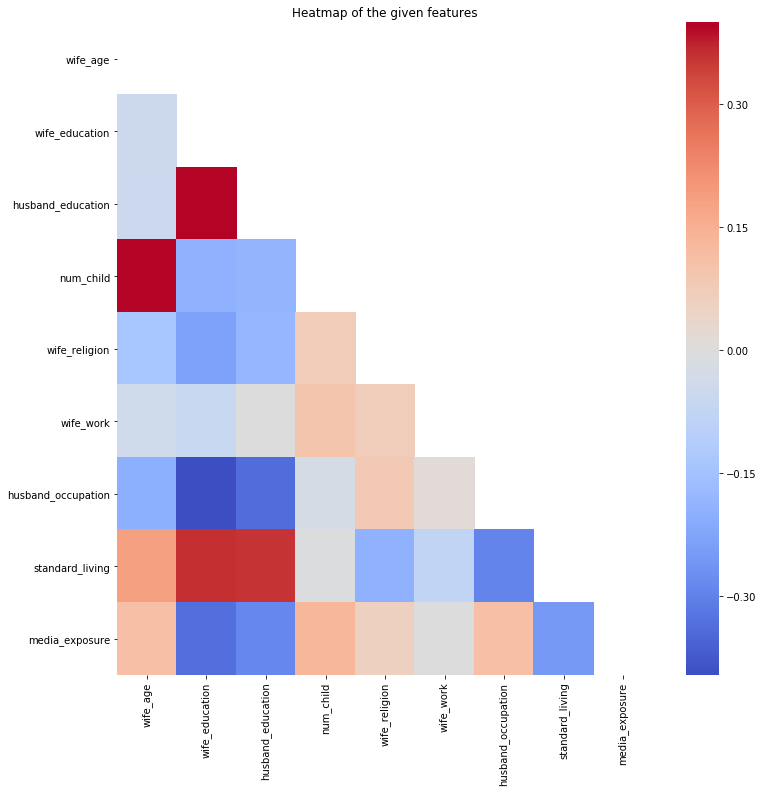

In [19]:
# Compute the correlation matrix
corr = contra.copy().drop(columns=['contraceptive']).corr()

#Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(12, 12))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap='coolwarm', vmax=.4, center=0).set_title("Correlation between features")
plt.title("Heatmap of the given features")

In [20]:
def pca_plot(df, plot = 'scree', with_std = True):
    df_std = standardize(df.copy(), with_std)
    u, s, vt = np.linalg.svd(df_std, full_matrices=False)
    #pcs = df @ vt[:2].T
    pcs = df @ vt.T
    hues = contra['type']
    if plot == 'scree':
        plt.plot(range(1, len(s) + 1), s**2/sum(s**2))
        plt.xticks(range(1, len(s) + 1))
        plt.title("Proportion of Variance vs Principal Component #")
        plt.xlabel("Principal Component #")
        plt.ylabel("Proportion of Variance");
    elif plot == 'first':
        #project data to first pc and plot
        sns.stripplot(x = hues, y= pcs[0])
        plt.title("Strip Plot of Principal Component 1")
        plt.ylabel("PC 1 Value");
    elif plot == 'second':
        pcs = df @ vt[:2].T
        fig = sns.scatterplot(x = pcs[0], y = pcs[1], hue = hues, palette = 'coolwarm', legend = 'full')
        plt.xlabel("PC1")
        plt.ylabel("PC2");
    else:
        raise Exception("Plot type '{}' does not exist".format(plot))

https://support.minitab.com/en-us/minitab/18/help-and-how-to/modeling-statistics/multivariate/how-to/principal-components/interpret-the-results/key-results/


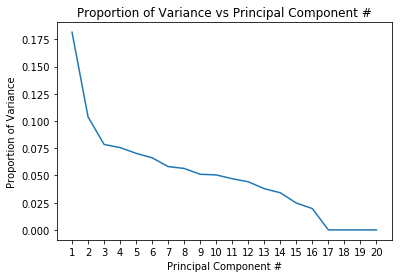

In [21]:
pca_plot(design(contra, phi0))

*The plot above shows that the variance of the data is very spread out across principal components.
Beacause of this imensionality reduction would likely be a bad choice.*

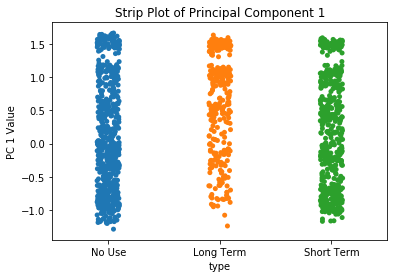

In [22]:
pca_plot(design(contra, phi0), 'first')

Text(0.5, 1.0, 'PCA using First 2 Principal Components')

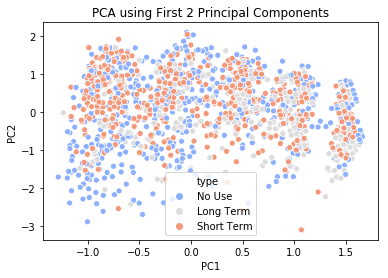

In [23]:
pca_plot(design(contra, phi0), "second")
plt.title("PCA using First 2 Principal Components")

*The results of projecting the data onto the first 2 principal components agrees with the
scree plot above. It is difficult to discern any sort of meaningful relationship between the projected data
and the type of contraceptive used.*

Text(0.5, 1.0, 'Box Plot of Wife Age vs Contraceptive Method Used')

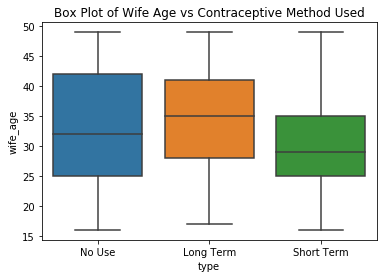

In [24]:
sns.boxplot(x = 'type', y = "wife_age", data = contra)
plt.title("Box Plot of Wife Age vs Contraceptive Method Used")

*Analyzing the box plot above, it appears that on average for this dataset,
younger woman prefered to use no birth control or use it for a short term, while order women
prefered to use long term birth control.*

Text(0.5, 1.0, 'Proportion of Muslim and Non Muslim Women for each Contraceptive Method Used')

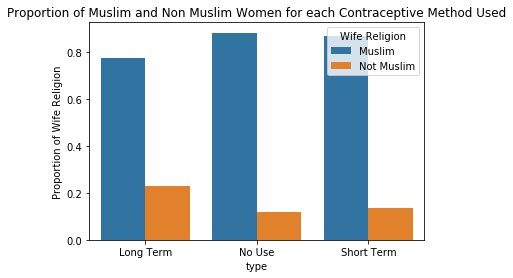

In [25]:
contra['Wife Religion'] = contra['wife_religion'].replace({0:"Not Muslim", 1 : "Muslim"})
def feature_percentage(feature):
    temp = contra.groupby(['type'])[feature].value_counts().groupby('type') \
        .apply(lambda x:  x / float(x.sum()))
    df = pd.DataFrame(temp)
    return df.rename(columns = {feature : "Proportion of " + feature}).reset_index()
df = feature_percentage("Wife Religion")
sns.barplot(x = "type", y = "Proportion of Wife Religion",  hue = "Wife Religion", data = df)
plt.title("Proportion of Muslim and Non Muslim Women for each Contraceptive Method Used")

Text(0.5, 1.0, 'Proportion of Husband Education for each Contraceptive Method Used')

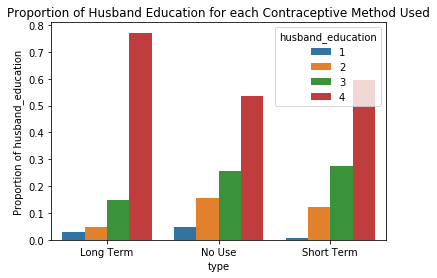

In [26]:
df = feature_percentage("husband_education")
sns.barplot(x = "type", y = "Proportion of husband_education",  hue = "husband_education", data = df)
plt.title("Proportion of Husband Education for each Contraceptive Method Used")

Text(0.5, 1.0, 'Proportion of Wife Education for each Contraceptive Method Used')

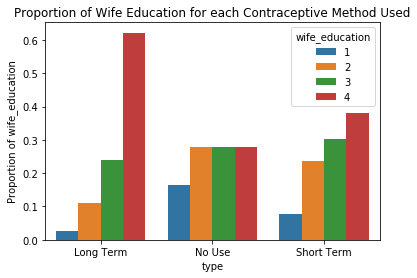

In [27]:
df = feature_percentage("wife_education")
sns.barplot(x = "type", y = "Proportion of wife_education",  hue = "wife_education", data = df)
plt.title("Proportion of Wife Education for each Contraceptive Method Used")

Standard of Living, Wife Edu, Husband Edu, all have very high percentages in the 'best' score for these long term, while short term is not as high. Maybe rich, more educated people tend to use birth
control more long term then short term, so even though the proportion of long term data is lower then short term, it may be easier to predict long term since so many of the long term ppl are so distincly educated and wealthy. This references the unexpected outcome of precision for short term vs long term. The no use was as expected, also was the highest proportion so the sheer amount of data likely overpowered the predictive power of long term. Note: This descrepancy occured in random forests but not in logistic regression. Ask TAS if we should be doing confusion matrix on test or train.

#### Split cleaned data into train and test data

In [20]:
X_train, X_test, y_train, y_test = train_test_split(design(contra, phi0), contra[['type']], test_size = .1, random_state = 42)

# Model 1. Logistic Regression

In [99]:
logistic_model = LogisticRegressionCV(multi_class = 'auto', max_iter = 1000, random_state=42)
logistic_model.fit(X_train, y_train)
y_hat = logistic_model.predict(X_train)

##### Avergage Validation Accuracy

In [100]:
cross_val_avg = np.mean(cross_val_score(logistic_model, X_train, y_train))
print("Final Training Accuracy:", accuracy_score(y_hat, y_train))
print("Final Validation Accuacy:", cross_val_avg)

Final Training Accuracy: 0.5154716981132076
Final Validation Accuacy: 0.5079245283018868


##### Precision vs Recall vs Accuracy

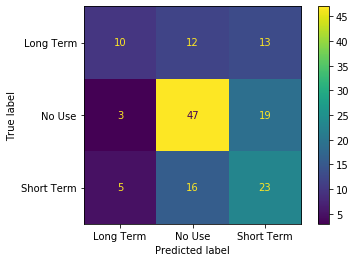

In [101]:
plot_confusion_matrix(logistic_model, X_test, y_test)

In [102]:
logistic_model.fit(X_train, y_train)
y_hat_test = logistic_model.predict(X_test)
print(classification_report(y_test, y_hat_test))

              precision    recall  f1-score   support

   Long Term       0.56      0.29      0.38        35
      No Use       0.63      0.68      0.65        69
  Short Term       0.42      0.52      0.46        44

    accuracy                           0.54       148
   macro avg       0.53      0.50      0.50       148
weighted avg       0.55      0.54      0.53       148



In [26]:
y_hat_test = logistic_model.predict(X_test)
print("Final Test Accuracy:", accuracy_score(y_test, y_hat_test))

Final Test Accuracy: 0.5405405405405406


In [27]:
def simple_model(model_name):
    train_acc, val_acc, test_acc = 0,0,0
    if model_name == 'decision tree':
        model = DecisionTreeClassifier(random_state = 10)
    elif model_name == 'random forest':
        model = RandomForestClassifier(bootstrap =  True)
        
    model.fit(X_train, y_train)
    train_acc = accuracy_score(y_train, model.predict(X_train))
    val_acc = np.mean(cross_val_score(model, X_train, y_train))
    test_acc = accuracy_score(y_test, y_hat_test)
    return train_acc, val_acc, test_acc

In [28]:
def plot_graph(train_accuracy, val_accuracies, x_axis, name):
    plt.plot(x_axis, train_accuracy, label = "Training Accuracy")
    plt.plot(x_axis, val_accuracies, label = "Validation Accuracy")
    plt.legend(loc='best')
    xlabel, title = "", ""
    if name == 'num trees':
        xlabel = "Number of Trees"
        title = "Training & Validation Accuracies vs Number of Trees"
    elif name == 'max_features':
        xlabel = "Number of Trees"
        title = "Training & Validation Accuracies vs max features used."
    elif name == "depth":
        xlabel = "Depth"
        title = "Training & Validation Accuracies vs Depth"    
    else:
        xlabel = "Feature Functions"
        title = "Training & Validation Accuracies vs Different Feature Functions"
        plt.xticks(rotation=45)
    plt.ylabel('Accuracy')
    plt.xlabel(xlabel)
    plt.title(title)

In [29]:
def max_depth_tuning(model_name, max_depth, best_n_estimator = 1000):
    val_accuracies = []
    train_accuracies = []
    for d in max_depth:
        if model_name == 'decision tree':
            model = DecisionTreeClassifier(max_depth = d, random_state = 10)
        elif model_name == 'random forest':
            model = RandomForestClassifier(n_estimators = best_n_estimator, max_depth = d, bootstrap = True, random_state = 10)
        model.fit(X_train, y_train)
        train_accuracies.append(accuracy_score(y_train, model.predict(X_train)))
        cross_val_avg = np.mean(cross_val_score(model, X_train, y_train))
        val_accuracies.append(cross_val_avg)
    return train_accuracies, val_accuracies

# Model 2. Decision Tree

### Attempt #1: Simple Naive model

In [91]:
train_acc, val_acc, test_acc = simple_model("decision tree")
print("Training Accuracy", train_acc)
print("Validation Accuracy", val_acc)
print("Test Accuracy:", test_acc)

Training Accuracy 0.9471698113207547
Validation Accuracy 0.4460754135432133
Test Accuracy: 0.5405405405405406


### Attempt #2: Tuning max depth

We get the best validation accuracy at depth 4 with validation accuracy 0.5486881108976448


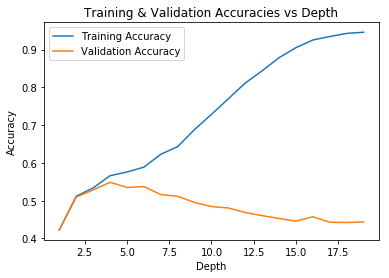

In [92]:
depth_range = np.arange(1,20)
train_acc, val_acc = max_depth_tuning("decision tree", depth_range)
plot_graph(train_acc,val_acc, depth_range, "depth")
best_depth = depth_range[np.argmax(val_acc)]
print("We get the best validation accuracy at depth {} with validation accuracy {}".format(best_depth, max(val_acc)))

### Attempt #3: Tuning max feartures

*Based on our previous result, we achieve the maximum validation accuracy at depth 4*

*We will fix depth =4  in the following max feature tuning*

In [93]:
def max_feature_tuning(min_samples_splits):
    val_accuracies = []
    train_accuracies = []
    for max_feature in max_features:
        dt= DecisionTreeClassifier(max_features=max_feature,max_depth = 4 , random_state = 10)
        dt.fit(X_train, y_train)
        train_accuracies.append(accuracy_score(y_train, dt.predict(X_train)))
        cross_val_avg = np.mean(cross_val_score(dt, X_train, y_train))
        val_accuracies.append(cross_val_avg)
    return train_accuracies, val_accuracies

We get the best validation accuracy with 11 max features and with validation accuracy 0.5516790273861049


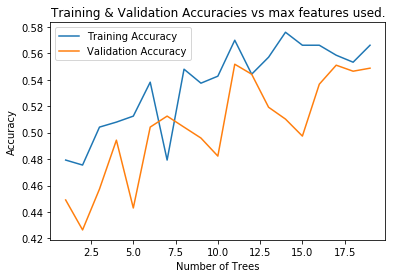

In [94]:
max_features = list(range(1,X_train.shape[1]))
train_acc, val_acc = max_feature_tuning(max_features)
plot_graph(train_acc, val_acc, max_features, "max_features")
best_features = max_features[np.argmax(val_acc)]
print("We get the best validation accuracy with {} max features and with validation accuracy {}".format(best_features, max(val_acc)))

*As we can see, upon tuning the max_feature parameter, our model validation accuracy imporved to 0.5516!*

*In conclusion, using a single a decision tree does not provide good prediction results dude to High Variance. One way to solve this is to consider a random forest which relies on randomized decision trees on random subsamples. Random Forest relies on the concept of taking the majority of votes when it comes to prediction.As a result, this reduces Variance.*

# Model 3. Random Forest

### Attempt #1: Simple Naive model

In [67]:
train_acc, val_acc, test_acc = simple_model("random forest")
print("Training Accuracy", train_acc)
print("Validation Accuracy", val_acc)
print("Test Accuracy:", test_acc)

Training Accuracy 0.9471698113207547
Validation Accuracy 0.5192453786199637
Test Accuracy: 0.5405405405405406


*Our simple model for random forest achieved 0.51924 average validation accuracy which was much higher than the simple model of decision trees!*

### Attempt #2:  Tuning number of trees

In [95]:
def num_trees_tuning(n_estimators):
    val_accuracies, train_accuracies = [], []
    for n in n_estimators:
        rf = RandomForestClassifier(n_estimators = n, bootstrap = True, random_state = 10)
        rf.fit(X_train, y_train)
        train_accuracies.append(accuracy_score(y_train, rf.predict(X_train)))
        cross_val_avg = np.mean(cross_val_score(rf, X_train, y_train))
        val_accuracies.append(cross_val_avg)
    return train_accuracies, val_accuracies

We get the best validation accuracy with 3000 number of trees and  with validation accuracy 0.5215044405424168


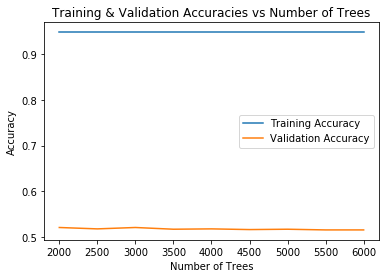

In [96]:
n_estimators = np.arange(2000,6001, 500)
train_acc, val_acc = num_trees_tuning(n_estimators)
plot_graph(train_acc, val_acc, n_estimators, 'num trees')
best_num = n_estimators[np.argmax(val_acc)]
print("We get the best validation accuracy with {} number of trees and  with validation accuracy {}".format(best_num, max(val_acc)))

### Attempt #3: Max Depth Tuning

*Based on our previous result, we achieve the maximum validation accuracy at 3000 decision trees*

*We will fix n_estimators = 3000 in the following max depth tuning*

We get the best validation accuracy at depth 6 with validation accuracy 0.5494389236222991


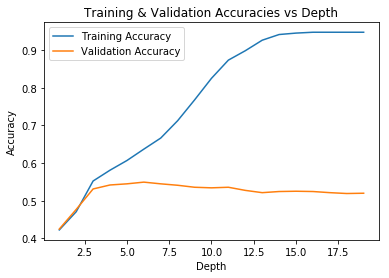

In [97]:
depth_range = np.arange(1,20)
train_acc, val_acc = max_depth_tuning("random forest", depth_range, 3000)
plot_graph(train_acc,val_acc, depth_range, "depth")
best_depth = depth_range[np.argmax(val_acc)]
print("We get the best validation accuracy at depth {} with validation accuracy {}".format(best_depth, max(val_acc)))

### Attempt #4: Mixed Hyperparameter Tuning

In [28]:
X_train_f, X_test_f, y_train_f, y_test_f = train_test_split(design(contra, phi0), contra[['contraceptive']], test_size = .1, random_state = 42)

#### 1. Random Parameter Grid

In [98]:
#number of trees in random forest
n_estimators = np.arange(7000, 10000, 600)

#depth of the tree
max_depth = np.arange(10,120,20)

#minimum number of samples required to split the node
min_samples_split = [5,10,15,20]

#method of selecting samples for training each tree
#bootstrap = [True, False]


#random grid
random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split}
               #'bootstrap': bootstrap}

In [29]:
# Use the random grid to search for best hyperparameters
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 10, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train_f, y_train_f)

NameError: name 'random_grid' is not defined

In [43]:
rf_random.best_params_

{'n_estimators': 7000, 'min_samples_split': 15, 'max_depth': 10}

#### 2. Grid Search

In [44]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'max_depth': [10,15],
    'min_samples_split': [12,15,18],
    'n_estimators': [7000,7200,7500]
}


In [45]:
from sklearn.model_selection import GridSearchCV

rf = RandomForestRegressor()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 3, n_jobs = -1, verbose = 2)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:  3.6min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jo

#### 3. Design the model based on the optimal parameters found

In [30]:
rf_best = RandomForestClassifier(n_estimators=7200, max_depth = 10, min_samples_split = 18, bootstrap =  True, random_state=42)
cross_val_avg = np.mean(cross_val_score(rf_best, X_train, y_train))

In [31]:
print("Random Forest Cross Val Score for attempt #4")
cross_val_avg

Random Forest Cross Val Score for attempt #4


0.5547169811320755

*After utilizing Random Search and Grid Search to tune our hyperparameters, we concluded that using 7200 trees, a max depth of 10, and 18 as our minimum samples split optimizes our accuracy of our random forest model.*

*Our accuracy improved from 0.539 to 0.56528!*

*Now we will try lifting the continuous variables to 
a new feature using various transformations*

In [104]:
def phi0(X, columns):

    for column in columns:
        X[column] = standardize(X[[column]])[column]
        
    return X

def phi1(X, columns):
    
    for column in columns:
        X[column] = standardize(X[[column]])[column]
        X['tanh(' + column + ')'] = np.tanh(X[column])
        
    return X

def phi2(X, columns):

    for column in columns:
        X[column] = standardize(X[[column]])[column]
        X['tanh(' + column + ')'] = np.tanh(X[column])
        X[column + "^2"] = X[column]**2
        
    return X

def phi3(X, columns):

    for column in columns:
        X[column] = standardize(X[[column]])[column]
        X['tanh(' + column + ')'] = np.tanh(X[column])
        X[column + "^2"] = X[column]**2
        X[column + "^3"] = X[column]**3
        
    return X

def phi4(X, columns):
    
    for column in columns:
        X[column] = standardize(X[[column]])[column]
        X['tanh(' + column + ')'] = np.tanh(X[column])
        X[column + "^2"] = X[column]**2
        X[column + "^3"] = X[column]**3
        X[column + "^4"] = X[column]**4
        
    return X

def phi5(X, columns):

    for column in columns:
        X[column] = standardize(X[[column]])[column]
        X['tanh(' + column + ')'] = np.tanh(X[column])
        X[column + "^2"] = X[column]**2
        X[column + "^3"] = X[column]**3
        X[column + "^4"] = X[column]**4
        X[column + "^5"] = X[column]**5
        
    return X

def phi_ellipsoid(X, columns):
    
    for i in columns:
        X[i] = standardize(X[[i]])[i]
        for j in columns:
            if i == j:
                X[i + "^2"] = X[i]**2
            else:
                X[i + " * " + j] = X[i] * X[j]
    return X
                
def parabaloid(X, columns):
    
    for column in columns:
        X[column] = standardize(X[[column]])[column]
        X['norm^2_of_' + column] = np.linalg.norm(X[column])**2
        
    return X

feature_funcs = [phi0, phi1, phi2, phi3, phi4, phi5, phi_ellipsoid, parabaloid]



In [ ]:
val_acc, train_acc = [], []
func_names = ['phi0', 'phi1', 'phi2', 'phi3', 'phi4', 'phi5', 'phi_ellipsoid', 'parabaloid']
for phi in feature_funcs:
    X_train, X_test, y_train, y_test = \
        train_test_split(design(contra, phi), contra[['contraceptive']], test_size = .1, random_state = 42)
    rf_best.fit(X_train, y_train)
    train_acc.append(accuracy_score(y_train, rf_best.predict(X_train)))
    cross_val_avg = np.mean(cross_val_score(rf_best, X_train, y_train))
    val_acc.append(cross_val_avg)

([0, 1, 2, 3, 4, 5, 6, 7], <a list of 8 Text xticklabel objects>)

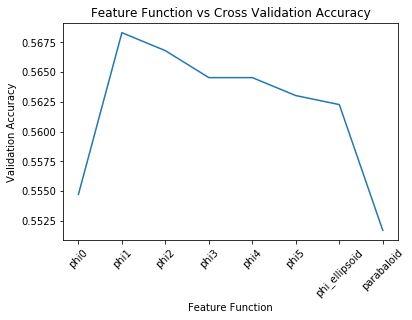

In [85]:
plot_graph(train_acc, val_acc, func_names, val_acc)

*Confusion Matrix for the best Random Forest Algorithm using the best feature function phi1*

In [32]:
X_train, X_test, y_train, y_test = \
        train_test_split(design(contra, phi1), contra[['type']], test_size = .1, random_state = 42)
rf_best.fit(X_train, y_train)
y_hat_train = rf_best.predict(X_train)
# confusion_matrix(y_test, y_hat)

NameError: name 'phi1' is not defined

In [ ]:
plot_confusion_matrix(rf_best, X_test, y_test)

In [88]:
print("Training Accuracy:", accuracy_score(y_train, y_hat_train))
print("Validation Accuracy:", np.mean(cross_val_score(rf_best, X_train, y_train)))

Training Accuracy: 0.6822641509433962
Validation Accuracy: 0.5683018867924529


In [89]:
y_hat_train = rf_best.predict(X_train)
print("Test Accuracy:", accuracy_score(y_test,y_hat))

Test Accuracy: 0.5945945945945946


In [83]:
report = classification_report(y_test, y_hat)
print(report)

              precision    recall  f1-score   support

   Long Term       0.64      0.40      0.49        35
      No Use       0.71      0.68      0.70        69
  Short Term       0.45      0.61      0.52        44

    accuracy                           0.59       148
   macro avg       0.60      0.56      0.57       148
weighted avg       0.62      0.59      0.60       148



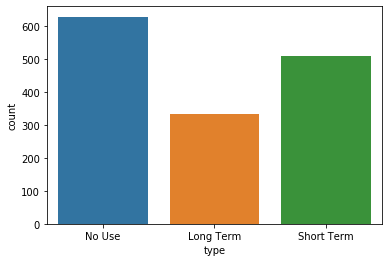

In [79]:
sns.countplot(data=contra, x = 'type')

**Precision** measures the proportion $\frac{\text{TP}}{\text{TP} + \text{FP}}$ 

**Recall** measures the proportion $\frac{\text{TP}}{\text{TP} + \text{FN}}$ 

**False-alarm rate** measures the proportion $\frac{\text{FP}}{\text{FP} + \text{TN}}$ 

*It was fishy to me that there was more data in the 'Short Term' 
class then the 'Long Term' yet there was higher precision in the 'Short Term'
class then the 'Long Term'. Analyzing the proportions of certain
features such as wife_education, husband_education, and standard_living showed that
there was a disproportionate amoung of rich and highly educated people that were 
on Long Term contraceptives vs Short Term. This likely made the predictive power
of these features much more profound for Long Term vs Short Term, which
would explain why the predictions were more precise, despite the algorithm seeing
less examples for the long term class*

*I realized that much of the 'No Use' and 'Short Term' birth control
results had similar proportion in' terms of the features husband education, 
wife education, and standard of living, but that Long Term Use was distinctly 
full of 'super smart rich' people. I decided to combine 'No Use' and 'Short Term'
into a single class assigned to 0 and Long Term Use assigned to class 1, making 
this a binary classification problem. The results on prediction improved significantly.*


# Testing the Models on the Binary Problem: Long Term vs No Use/Short Term

In [56]:
contra['type2'] = contra['contraceptive'].replace({1: 0, 2: 1, 3 : 0})

In [78]:
X_train_2class, X_test_2class, y_train_2class, y_test_2class = \
    train_test_split(design(contra, phi0), contra[['type2']], test_size = .3, random_state = 42)

X_test_2class, X_valid_2class, y_test_2class, y_valid_2class = \
    train_test_split(X_test_2class, y_test_2class, test_size = .5, random_state = 42)

In [74]:
logistic_model = LogisticRegressionCV(max_iter = 1000, random_state=42)
logistic_model.fit(X_train_2class, y_train_2class)
y_hat = logistic_model.predict(X_train_2class)

In [75]:
cross_val_avg = np.mean(cross_val_score(logistic_model, X_train_2class, y_train_2class))
print("Validation Accuracy Best Logistic Regression:", cross_val_avg)

Validation Accuracy Best Logistic Regression: 0.7720651001360161


In [80]:
y_hat_valid = logistic_model.predict(X_test_2class)

In [81]:
cross_val_avg = np.mean(cross_val_score(rf_best, X_train_2class, y_train_2class))

In [82]:
print("Validation Average Best Random Forest:", cross_val_avg)

Validation Average Best Random Forest: 0.7982505510998545


In [83]:
rf_best.fit(X_train_2class, y_train_2class)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=18,
                       min_weight_fraction_leaf=0.0, n_estimators=7200,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [93]:
# y_hat_test = rf_best.predict(X_test_2class)
# rf_test_score = accuracy_score(y_hat_test, y_test_2class)
# print("Test Accuracy Best Random Forest:", rf_test_score)

Test Accuracy Best Random Forest: 0.7837837837837838


In [85]:
report = classification_report(y_valid_2class, y_hat_valid)
print(report)

              precision    recall  f1-score   support

           0       0.78      0.97      0.86       172
           1       0.17      0.02      0.04        49

    accuracy                           0.76       221
   macro avg       0.47      0.50      0.45       221
weighted avg       0.64      0.76      0.68       221



Text(0.5, 1.0, 'Number of Samples for 2 Class Problem')

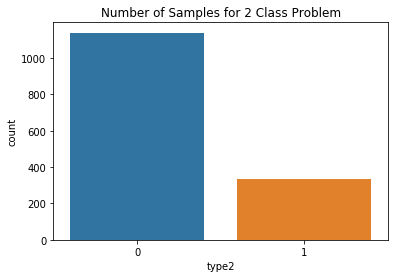

In [86]:
sns.countplot(data=contra, x = 'type2')
plt.title("Number of Samples for 2 Class Problem")


*It appears that transforming the three class problem into a 2 class
problem drastically improved the precision of the two new classes. However, 
while the recall was very high for the 0 class (No Use/Short Term)
the recall was very low for the Long Term class. For example, this
means that if a given sample was chosen to be 1, the algorithm was
likely correct in choosing 1 (precision). However, of all
the sample points that were actually 1, the algorithm classified only 14% of them
as being 1. This is likely due to the fact the data had a disproportionate amount 
0 classes vs 1*

# Over Sampling and Under Sampling 

In [87]:
steps_smote = [('over', SMOTE()), ('model', rf_best)]
steps_over = [('over', RandomOverSampler()), ('model', rf_best)]
steps_under = [('under', RandomUnderSampler()), ('model', rf_best)] 
pipeline_smote = Pipeline(steps=steps_smote)
pipeline_over = Pipeline(steps=steps_over)
pipeline_under = Pipeline(steps=steps_under)

In [88]:
pipelines = [pipeline_under, pipeline_over, pipeline_smote]

In [89]:
def under_over_smote(pipelines, X_train, y_train):
    pipeline_under, pipeline_over, pipeline_smote = pipelines
    cross_val_under = np.mean(cross_val_score(pipeline_under, X_train, y_train))
    cross_val_smote = np.mean(cross_val_score(pipeline_smote, X_train, y_train))
    cross_val_over = np.mean(cross_val_score(pipeline_over, X_train, y_train))
    return cross_val_under, cross_val_over, cross_val_smote

In [90]:
cross_val_under, cross_val_over, cross_val_smote = \
    under_over_smote(pipelines, X_train_2class, y_train_2class)

In [91]:
cross_val_under, cross_val_over, cross_val_smote

(0.6643543923830965, 0.7186998733642886, 0.7429341963322545)

In [94]:
pipeline_smote.fit(X_train_2class, y_train_2class)
y_hat_2class = pipeline_smote.predict(X_valid_2class)
print(classification_report(y_valid_2class, y_hat_2class))

              precision    recall  f1-score   support

           0       0.85      0.80      0.82       172
           1       0.41      0.49      0.44        49

    accuracy                           0.73       221
   macro avg       0.63      0.64      0.63       221
weighted avg       0.75      0.73      0.74       221



*Now our curiosity has been sparked on whether oversampling and undersampling would work on the original three class case. We attempt this below.*


In [38]:
X_train, X_test, y_train, y_test = \
    train_test_split(design(contra, phi0), contra[['type']], test_size = .1, random_state = 42)


In [39]:
cross_val_under, cross_val_over, cross_val_smote = under_over_smote(pipelines, X_train, y_train)

In [40]:
cross_val_under, cross_val_over, cross_val_smote

(0.5267924528301886, 0.539622641509434, 0.5494339622641509)

*Smote oversampling produced the best validation out of the three under/oversampling techniques.
It increased both precision and recall for class 1, however it still performed worse in terms of 
accuracy then the original random forest model without over/under sampling. We assume that for our 
purposes, accuracy is the most important metric, so we use the OG random forest as our final model.
However, someone else may have a different use case where precision and recall would be more important
then accuracy, to which they would likely want to use the random forest model with smote oversampling*

In [93]:
y_hat_test = rf_best.predict(X_test_2class)
rf_test_score = accuracy_score(y_hat_test, y_test_2class)
print("Test Accuracy Best Random Forest:", rf_test_score)

Test Accuracy Best Random Forest: 0.7647058823529411
